In [1]:
EXAMPLE_FILE="SpamData/01_Processing/practice_email.txt"

# Reading Files

In [2]:
import sys
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer,SnowballStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
stream=open(EXAMPLE_FILE,encoding='latin-1')

In [4]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True

email_body='\n'.join(lines)
print(email_body)
stream.close()



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [5]:
def generate_squares(N):
    for i in range(N):
        yield i **2

In [6]:
for i in generate_squares(4):
    print(i)

0
1
4
9


## Email Body Generation

In [7]:
def email_body_generation(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            filepath=join(root,file_name)
            stream=open(filepath ,encoding='latin-1')
            is_body=False
            lines=[]
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True
            stream.close()
            email_body='\n'.join(lines)
            yield file_name, email_body
            

In [8]:
def df_from_direc(path,classification):
    rows=[]
    row_names=[]
    for file_name,email_body in email_body_generation(path):
        rows.append({"MESSAGE":email_body, "CATEGORY":classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [9]:
SPAM_1_PATH="SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH="SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH="SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH="SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT=1
HAM_CAT=0

DATA_JSON_FILE="SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE="SpamData/01_Processing/word-by-id.csv"


WHALE_FILE="SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE="SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE="SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE="SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
bold_font="SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"
light_font="SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf"
TRAINING_DATA_FILE="SpamData/02_Training/trian-data.txt"
TEST_DATA_FILE="SpamData/02_Training/test-data.txt"
VOCAB_SIZE=2500

In [10]:
spam_email=df_from_direc(SPAM_1_PATH,SPAM_CAT)
spam_email=spam_email.append(df_from_direc(SPAM_2_PATH,SPAM_CAT))

In [11]:
ham_email=df_from_direc(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_email=ham_email.append(df_from_direc(EASY_NONSPAM_2_PATH,HAM_CAT))

In [12]:
data= pd.concat([spam_email,ham_email])

In [13]:
data.shape

(5799, 2)

## Data Cleaning : Check Missing Values

In [14]:
# check is null
data.MESSAGE.isnull().sum()

0

In [15]:
(data.MESSAGE.str.len() == 0).sum()

3

## Locate Empty Emails

In [16]:
em=data[data.MESSAGE.str.len() == 0].index

In [17]:
data.loc['cmds',:]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [18]:
data=data.drop(em[0])

In [19]:
data.shape

(5796, 2)

## Add Document ID to track emails is Dataset

In [20]:
doc_id=range(0,len(data))
data.loc[data.index,'DOC_ID']=doc_id

In [21]:
data['FILE_NAME']=data.index
data.set_index('DOC_ID',inplace=True)

In [22]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


In [23]:
data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=5796)

## Save to File using Pandas

In [24]:
data.to_json(DATA_JSON_FILE)

## Number Spam Message Visualization (PIE CHART)

In [25]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amt_spam=data.CATEGORY.value_counts()[1]
amt_ham=data.CATEGORY.value_counts()[0]

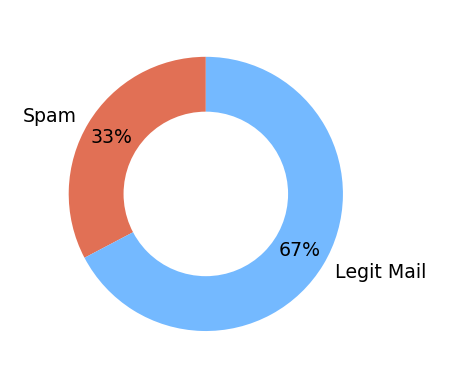

In [27]:
category_names=["Spam","Legit Mail"]
sizes=[amt_spam,amt_ham]
custom_colors=['#e17055','#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,
       autopct='%1.0f%%',colors=custom_colors,pctdistance=0.8)
#draw circle
center_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()

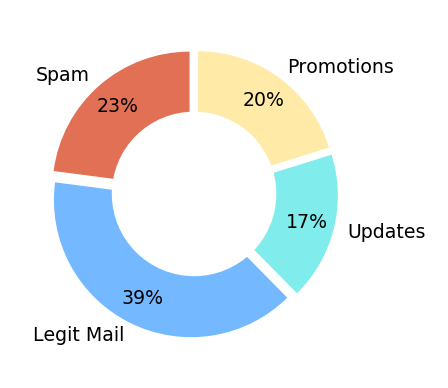

In [28]:
category_names=["Spam","Legit Mail","Updates","Promotions"]
sizes=[25,43,19,22]
custom_colors=['#e17055','#74b9ff','#81ecec','#ffeaa7']
offset=[0.05,0.05,0.05,0.05]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,
       autopct='%1.0f%%',colors=custom_colors,pctdistance=0.8,explode=offset)
#draw circle
center_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()

## Natural Language Processing
### Text Pre-Preocessing

## Remove Stop words

In [29]:
stop_words=set(stopwords.words('english'))

In [30]:
msg="All day we are playing outside"
words1=word_tokenize(msg.lower())
filtered=[]
for word in words1:
    if word not in stop_words:
        filtered.append(word)

In [31]:
filtered

['day', 'playing', 'outside']

## Word Stemming

In [32]:
msg="All day we are playing outside. \
Nobody expects Spanish inquistion"

words1=word_tokenize(msg.lower())

stemmer=PorterStemmer()
#stemmer=SnowballStemmer('english')

filtered=[]
for word in words1:
    if (word not in stop_words and word.isalpha()==True):
        filtered.append(stemmer.stem(word))

In [33]:
filtered

['day', 'play', 'outsid', 'nobodi', 'expect', 'spanish', 'inquist']

## Remove HTML tags

In [34]:
soup=BeautifulSoup(data.at[0,"MESSAGE"],'html.parser')
print(soup.get_text())















<=

/TR>
Save up to 70% on Life Insurance.
Why Spend More Than You Have To?


Life Quote Savings











Ensurin=

g your 

      family's financial security is very important. Life Quote Savings ma=

kes 

      buying life insurance simple and affordable. We Provide FREE Access =

to The 

      Very Best Companies and The Lowest Rates.





Life Quote Savings is FAST, EAS=

Y and 

            SAVES you money! Let us help you get started with the best val=

ues in 

            the country on new coverage. You can SAVE hundreds or even tho=

usands 

            of dollars by requesting a FREE quote from Lifequote Savings. =

Our 

            service will take you less than 5 minutes to complete. Shop an=

d 

            compare. SAVE up to 70% on all types of Life insurance! 




Click Here For Your=

 

            Free Quote!

Protecting your family is the best investment you'll eve=

r 

          make!








If you are in receipt of this=

 email 

      in

## Functions For Email Processing

In [35]:
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    #Remove HTML Tags
    soup=BeautifulSoup(message,'html.parser')
    clean_text=soup.get_text()
    
    #Converst to lower case and tokenize
    words=word_tokenize(clean_text.lower())
    filtered=[]
    for word in words:
        ## Removes stop words and punctuations
        if (word not in stop_words and word.isalpha()==True):
            filtered.append(stemmer.stem(word))
    return filtered

In [36]:
%%time
nested_list=data.MESSAGE.apply(clean_msg_no_html)

C:\Users\pavan\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 54.3 s


In [37]:
doc_ids_spam=data[data.CATEGORY==1].index

In [38]:
doc_ids_ham=data[data.CATEGORY==0].index

In [39]:
nested_list_ham=nested_list.loc[doc_ids_ham]
nested_list_spam=nested_list.loc[doc_ids_spam]

In [40]:
tot_words_ham=[word for word_list in nested_list_ham for word in word_list]
tot_words_spam=[word for word_list in nested_list_spam for word in word_list]

In [41]:
ham_words=pd.Series(tot_words_ham).value_counts()
spam_words=pd.Series(tot_words_spam).value_counts()
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating WordCloud

In [42]:
# nltk.download('gutenberg')
# nltk.download('shakespeare')

In [43]:
ex_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [44]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

word_list=[''.join(word) for word in ex_corpus]
novel_string=' '.join(word_list)

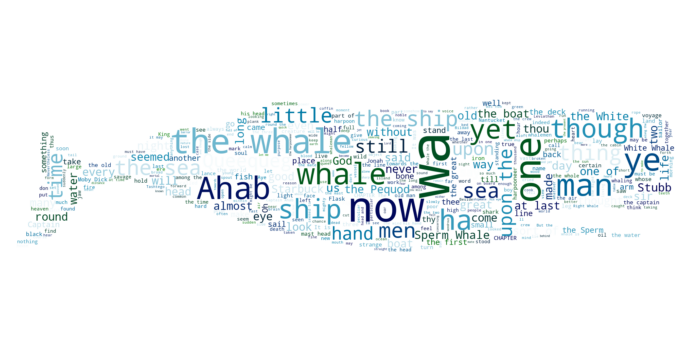

In [45]:
word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='ocean').generate(novel_string)
plt.figure(figsize=[12,8])
plt.imshow(word_cloud,interpolation='bilinear',)
plt.axis('off')
plt.show()

In [46]:
ex_corpus_t=nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

In [47]:
icon=Image.open(SKULL_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)

word_list=[''.join(word) for word in ex_corpus_t]
novel_string=' '.join(word_list)

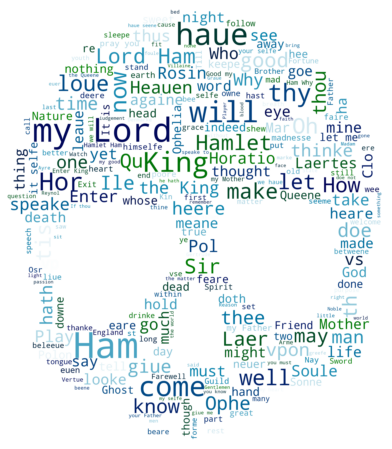

In [48]:
word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=250,colormap='ocean').generate(novel_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham Data

In [77]:
icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)
ham_str=' '.join(tot_words_ham)

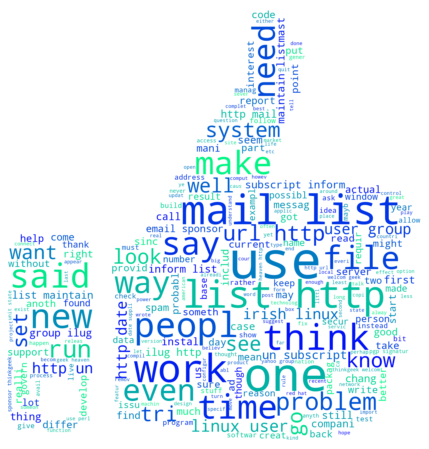

In [78]:
word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=250,colormap='winter').generate(ham_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [79]:
icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)
spam_str=' '.join(tot_words_spam)

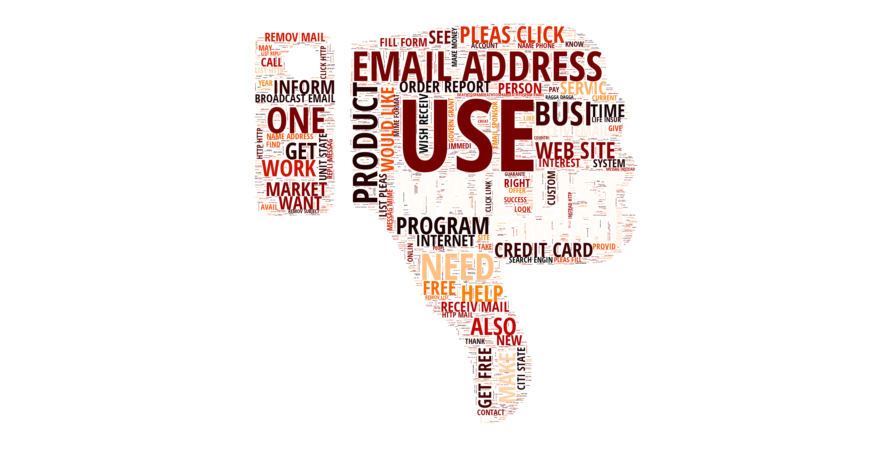

In [80]:
word_cloud=WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat_r',
                     font_path=bold_font,min_word_length=3,max_font_size=300).generate(spam_str.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [81]:
flat_stemmed_list=[ item for sublist in nested_list for item in sublist]

In [82]:
unique_words=pd.Series(flat_stemmed_list).value_counts()

In [83]:
freq_words=unique_words[0:VOCAB_SIZE]

In [84]:
freq_words[0:VOCAB_SIZE].values

array([10662,  5017,  4852, ...,    44,    44,    44], dtype=int64)

## Create Vocab DatafRame with WORD_ID

In [85]:
word_ids=list(range(0,VOCAB_SIZE))
VOCAB_DF=pd.DataFrame(data={'VOCAB_WORD':freq_words.index.values,'VOCAB_COUNT':freq_words[0:VOCAB_SIZE].values},index=word_ids)
VOCAB_DF.index.name="WORD_ID"

In [86]:
VOCAB_DF

,VOCAB_WORD,VOCAB_COUNT
WORD_ID,,
0,http,10662
1,use,5017
2,list,4852
3,email,4370
4,get,4187
...,...,...
2495,maxaman,44
2496,pleasur,44
2497,distributor,44


In [87]:
VOCAB_DF.to_csv(WORD_ID_FILE,index_label=VOCAB_DF.index.name,header=VOCAB_DF.columns)

## Check if a word is in vocabulary

In [88]:
check_words=['machine','learning','fun','learn','data','science','app','brewery']

In [89]:
search=[i in list(VOCAB_DF.VOCAB_WORD) for i in check_words]

In [90]:
search

[False, False, True, True, True, False, True, False]

## Find the Email with Most Number Of Words

In [91]:
len(nested_list[0])

92

In [92]:
clean_mails_length=pd.Series([len(i) for i in nested_list])

In [93]:
data.at[np.argmax(clean_mails_length),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features And Sparse Matrix

In [94]:
word_columns_df=pd.DataFrame.from_records(nested_list.to_list())

In [95]:
word_columns_df.shape

(5796, 7671)

In [96]:
X=word_columns_df
y=data.CATEGORY

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [97]:
X_train.index.name=X_test.index.name="DOC_ID"

In [98]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5389,ideal,mailwal,allow,messag,passthrough,mani,way,sender,membership,person,...,None,None,None,None,None,None,None,None,None,None
148,new,web,technolog,unlimit,web,ferenc,subscrib,web,confer,enter,...,None,None,None,None,None,None,None,None,None,None
3347,despit,lack,confid,upgrad,use,tarbal,instead,cpan,work,help,...,None,None,None,None,None,None,None,None,None,None
5737,wed,aug,brad,angelcyk,wrote,hi,use,spamassassin,week,notic,...,None,None,None,None,None,None,None,None,None,None
1045,databas,click,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,want,teach,grow,rich,motiv,qualifi,commun,person,train,minut,...,None,None,None,None,None,None,None,None,None,None
505,cpurf,x,x,x,x,x,x,b,p,k,...,None,None,None,None,None,None,None,None,None,None
3011,angl,puglisi,angl,also,develop,rapidli,cv,look,like,next,...,None,None,None,None,None,None,None,None,None,None


## Create Sparse matrix for training data

In [99]:
word_index=pd.Index(VOCAB_DF.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'scenario', 'quarter', 'burner', 'rm', 'bob', 'maxaman', 'pleasur',
       'distributor', 'council', 'subsequ'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [100]:
def make_sparse_matrix(X_train, word_index,y_train):
    """
    Returns Sparse matrix as dataframe
    
    df: A dataframe with words in the columns with document id as an index
    indexed_words: index of words ordered by word_id
    """
    nrows=X_train.shape[0]
    ncols=X_train.shape[1]
    dict_list=[]
    word_set=set(word_index)
    for i in range(nrows):
        for j in range(ncols):
            WORD=X_train.iat[i,j]
            if(WORD in word_set):
                WORD_ID=word_index.get_loc(WORD)
                DOC_ID=X_train.index[i]
                LABEL=y_train.at[DOC_ID]
                item={"LABEL":LABEL,"DOC_ID":DOC_ID,"WORD_ID":WORD_ID,"OCCURENCE":1}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [101]:
%%time
sparse_train_df=make_sparse_matrix(X_train, word_index,y_train)

Wall time: 4min 28s


In [102]:
sparse_train_df

,LABEL,DOC_ID,WORD_ID,OCCURENCE
0,1,858,1896,1
1,1,858,1329,1
2,1,858,582,1
3,1,858,3,1
4,1,858,280,1
...,...,...,...,...
516359,1,872,175,1
516360,1,872,261,1
516361,1,872,28,1
516362,1,872,0,1


## Combine Occurences with Pandas groupby() Method

In [103]:
train_grouped=sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [104]:
train_grouped

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1
...                         ...
5795   2053    0              2
       2059    0              1
       2287    0              1
       2356    0              1
       2417    0              1

[304277 rows x 1 columns]

In [105]:
VOCAB_DF.at[0,'VOCAB_WORD']

'http'

In [106]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [107]:
train_grouped=train_grouped.reset_index()
train_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1
...,...,...,...,...
304272,5795,2053,0,2
304273,5795,2059,0,1
304274,5795,2287,0,1
304275,5795,2356,0,1


In [108]:
VOCAB_DF.at[2293,'VOCAB_WORD']

'pioneer'

In [109]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

## Save training file as .txt file

In [110]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [111]:
%%time
sparse_test_df=make_sparse_matrix(X_test, word_index,y_test)

Wall time: 1min 3s


In [112]:
sparse_test_df

,LABEL,DOC_ID,WORD_ID,OCCURENCE
0,0,5389,2287,1
1,0,5389,214,1
2,0,5389,10,1
3,0,5389,69,1
4,0,5389,36,1
...,...,...,...,...
117764,0,2571,2345,1
117765,0,2571,614,1
117766,0,2571,721,1
117767,0,2571,489,1


In [113]:
test_grouped=train_grouped=sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

In [114]:
test_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,2,0,1,6
1,2,1,1,1
2,2,2,1,1
3,2,4,1,1
4,2,7,1,1
...,...,...,...,...
71648,5792,510,0,1
71649,5792,525,0,1
71650,5792,666,0,1
71651,5792,794,0,1


In [115]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [ ]:
len(test_grouped.DOC_ID.unique())

In [ ]:
test_doc_ids=set(test_grouped.DOC_ID)
train_doc_ids=set(train_grouped.DOC_ID)

In [ ]:
set(X_test.index.values)- test_doc_ids

In [ ]:
data.MESSAGE[734]